In [1]:
import xarray as xr

In [2]:
import dask

In [3]:
import numpy as np

In [4]:
import xgcm
from typing import Annotated

In [5]:
from xhistogram.xarray import histogram

In [6]:
from xmitgcm.llcreader import faces_dataset_to_latlon

In [7]:
import hvplot.xarray

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl

### Open data 

In [9]:
def open_llc4320_velocity_data(chunks='auto'):
    
    ds_SSU = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/ssu", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    ds_SSV = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/ssv", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    # Open grid data
    ds_grid = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/grid", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    coords_to_keep = ['XC', 'YC', 'dxC', 'dyC', 'dxG', 'dyG', 'rAz', 'rA', 'Depth']
    ds_grid = ds_grid.reset_coords()[coords_to_keep]
    
    ds = xr.merge([ds_SSU, ds_SSV, ds_grid])
    return ds, ds_grid

In [10]:
ds, ds_grid = open_llc4320_velocity_data(chunks={})

In [11]:
# first downsample to daily data
#ds = ds.isel(time=slice(None, None, 48)) 

#first downsample to 3hrly data
ds = ds.isel(time=slice(None, None, 3)) 

In [12]:
ds.isel(time=slice(0,10)).time

<xarray.DataArray 'time' (time: 10)> Size: 80B
array(['2011-09-13T00:00:00.000000000', '2011-09-13T03:00:00.000000000',
       '2011-09-13T06:00:00.000000000', '2011-09-13T09:00:00.000000000',
       '2011-09-13T12:00:00.000000000', '2011-09-13T15:00:00.000000000',
       '2011-09-13T18:00:00.000000000', '2011-09-13T21:00:00.000000000',
       '2011-09-14T00:00:00.000000000', '2011-09-14T03:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 80B 2011-09-13 ... 2011-09-14T03:00:00
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

### Create xGCM grid

Only use a couple of faces and times to allow us to visualize task graph

In [13]:
#ds = ds.isel(face=slice(0,2), time=slice(0,2))
#ds_grid = ds_grid.isel(face=slice(0,2))

In [14]:
grid = xgcm.Grid(ds_grid, periodic=False)

### Define vort/strain/divergence calculation

In [15]:
lat = ds_grid['YC'].reset_coords(drop=True).rename('lat')

In [16]:
rotation_rate = 7.2921e-5  # rad/s
f_coriolis = (
    2 * rotation_rate * np.sin(lat*np.pi/180)
).rename('f_coriolis')
#ADDED
f_coriolis = f_coriolis.where(np.abs(f_coriolis)>1.3*10**-5, np.sign(f_coriolis)*1.3*10**-5)
#f_coriolis = f_coriolis.where(np.abs(f_coriolis)>5*10**-5, np.sign(f_coriolis)*5*10**-5)

f_coriolis

<xarray.DataArray 'f_coriolis' (face: 13, j: 4320, i: 4320)> Size: 970MB
dask.array<where, shape=(13, 4320, 4320), dtype=float32, chunksize=(1, 4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 35kB 0 1 2 3 4 5 6 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 35kB 0 1 2 3 4 5 6 ... 4313 4314 4315 4316 4317 4318 4319

We want to calculate the integral formula for [relative vorticity](https://mitgcm.readthedocs.io/en/latest/algorithm/algorithm.html?highlight=vorticity#relative-vorticity) in terms of circulation around a grid cell:

$$
  \zeta_3 = \frac{\Gamma}{A_\zeta} = \frac{1}{{\cal A}_\zeta} ( \delta_i \Delta y_c v - \delta_j \Delta x_c u )
$$

where $u$ and $v$ are horizontal and vertical components of surface velocity respectively.

In [17]:
@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",
)
def vort(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxc: Annotated[np.ndarray, "(Y:center,X:left)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyc: Annotated[np.ndarray, "(Y:left,X:center)"],
    raz: Annotated[np.ndarray, "(Y:left,X:left)"],
) ->     Annotated[np.ndarray, "(Y:left,X:left)"]:
    """Dimensional vorticity"""
    
    u_trans = u * dxc
    v_trans = v * dyc
    v_diff_x = v_trans[..., 1:, 1:] - v_trans[..., 1:, :-1]
    u_diff_y = u_trans[..., 1:, 1:] - u_trans[..., :-1, 1:]
    return (v_diff_x - u_diff_y) / raz[..., 1:, 1:]

In [18]:
ζ = vort(grid, ds.U, ds.dxC, ds.V, ds.dyC, ds.rAz, axis= 5 * [("Y", "X")], fill_value=np.nan)

/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [19]:
ζ = ζ.assign_coords({"time": ds.time.values})  # TODO won't need this line once xgcm #575 is fixed

In [20]:
ζ = ζ.rename({"i_g": "i", "j_g": "j"}).rename("vort")  # pretend it's now on cell centers to match other fields

In [21]:
# Normalise
# TODO: Would be neater to normalise inside grid ufunc but then we would also pad f unneccessarily
ζ = ζ / f_coriolis

In [22]:
#ζ

In [23]:
# with dask.config.set({'optimization.fuse.ave-width': 5, 'optimization.fuse.max-height': 20}):
#     graph = ζ.data.visualize(optimize_graph=True, color="order", cmap="autumn", node_attr={"penwidth": "4"})
    
# graph

We also want the **strain magnitude**, given by the vector magnitude of the two strain components, normal strain ($\sigma_n$) and shear strain ($\sigma_s$)

$$
\sigma = \sqrt{\sigma_n^2 + \sigma_s^2}
$$

where the components are given in terms of surface velocity components $u$ and $v$ as

$$
\sigma_n = \frac{\partial u}{\partial x} - \frac{\partial v}{\partial y}
$$
$$
\sigma_s = \frac{\partial v}{\partial x} + \frac{\partial u}{\partial y}
$$

In [24]:
@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",    
)
def strain(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxc: Annotated[np.ndarray, "(Y:center,X:left)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyc: Annotated[np.ndarray, "(Y:left,X:center)"],
) ->     Annotated[np.ndarray, "(Y:left,X:left)"]:
    u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
    v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
    u_diff_y = (u[..., 1:, :] - u[..., :-1, :]) / dyc[..., 1:, :]
    v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) / dyc[..., 1:, :]
    
    u_diff_x_trimmed = u_diff_x[..., 1:, :]
    v_diff_x_trimmed = v_diff_x[..., 1:, :]
    u_diff_y_trimmed = u_diff_y[..., 1:]
    v_diff_y_trimmed = v_diff_y[..., 1:]
    
    strain_normal = u_diff_x_trimmed - v_diff_y_trimmed
    strain_shear = v_diff_x_trimmed + u_diff_y_trimmed
    
    # TODO: interpolate the shear strain onto the positions of the normal strain
    # For now, we just pretend they are at the same grid point
    strain_mag = np.sqrt(strain_normal ** 2 +  strain_shear ** 2)
    
    return strain_mag

In [25]:
σ = strain(grid, ds.U, ds.dxC, ds.V, ds.dyC, axis=4 * [("Y", "X")], fill_value=np.nan)

/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [26]:
σ = σ.assign_coords({"time": ds.time.values})

In [27]:
σ = σ.rename({"i_g": "i", "j_g": "j"})

In [28]:
# Normalise
# TODO: Would be neater to normalise inside grid ufunc but then we would also pad f unneccessarily
σ = σ / abs(f_coriolis)

Finally we want **divergence**, defined as


$$
D = \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y}
$$

but [represented in MITgcm](https://mitgcm.readthedocs.io/en/latest/algorithm/algorithm.html?highlight=divergence#horizontal-divergence) as 

$$
D = \frac{1}{A_c h_c} \left( \delta_i \Delta y_g h_w u + \delta_j \Delta x_g h_s v\right)
$$

In [29]:
@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",
)
def divergence(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxg: Annotated[np.ndarray, "(Y:left,X:center)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyg: Annotated[np.ndarray, "(Y:center,X:left)"],
    ra:  Annotated[np.ndarray, "(Y:center,X:center)"],
) ->     Annotated[np.ndarray, "(Y:center,X:center)"]:
    
    u_diff_x = (u[..., 1:] - u[..., :-1]) * dxg[..., 1:]
    v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) * dyg[..., 1:, :]
    
    u_diff_x_trimmed = u_diff_x[..., 1:, :]
    v_diff_y_trimmed = v_diff_y[..., 1:]
    
    divergence = (u_diff_x_trimmed + v_diff_y_trimmed) / ra[..., 1:, 1:]
    
    return divergence

In [30]:
D = divergence(grid, ds.U, ds.dxG, ds.V, ds.dyG, ds.rA, axis= 5 * [("Y", "X")], fill_value=np.nan)# / abs(f_coriolis)

/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [31]:
D = D.assign_coords({"time": ds.time.values})

In [32]:
# Normalise
# TODO: Would be neater to normalise inside grid ufunc but then we would also pad f unneccessarily
D = D/10**-4 #/ abs(f_coriolis)

In [33]:
D

<xarray.DataArray (time: 3010, face: 13, j: 4320, i: 4320)> Size: 3TB
dask.array<truediv, shape=(3010, 13, 4320, 4320), dtype=float32, chunksize=(1, 1, 4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 35kB 0 1 2 3 4 5 6 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 35kB 0 1 2 3 4 5 6 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 24kB 2011-09-13 ... 2012-09-23T03:00:00

In [34]:
# merge everything
results = xr.merge(
    [
        ζ.rename("vort"),
        σ.rename("strain"),
        D.rename("div"),
        f_coriolis,
        ds_grid[['XC', 'YC', 'rA', 'Depth']]
    ]
).set_coords(['XC', 'YC', 'rA', 'Depth'])
results

<xarray.Dataset> Size: 9TB
Dimensions:     (face: 13, i: 4320, j: 4320, time: 3010)
Coordinates:
  * face        (face) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i           (i) int64 35kB 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
  * j           (j) int64 35kB 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
  * time        (time) datetime64[ns] 24kB 2011-09-13 ... 2012-09-23T03:00:00
    XC          (face, j, i) float32 970MB dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC          (face, j, i) float32 970MB dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rA          (face, j, i) float32 970MB dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth       (face, j, i) float32 970MB dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
Data variables:
    vort        (time, face, j, i) float32 3TB dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    strain      (time, face, j, i) float32 3TB dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    div         (time, face, j, i) float32 3TB dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    f_coriolis  (face, j, i) float32 970MB dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

### Coarsen fields into regions of interest

In [35]:
regions = results.coarsen(
    i=540,
    j=540,
).construct(
    i=("i_region_coarse", "i_region"),
    j=("j_region_coarse", "j_region"),
).stack(region=['face', 'i_region_coarse', 'j_region_coarse'])

In [36]:
# keep a unique number for each region
regions = regions.assign_coords(region_num=('region', np.arange(len(regions.region))))

### Store region bounds for later plotting

Save region vertices for reconstruction of regions

In [37]:
# "bottom-left"
vertex_1_x = regions['XC'].isel(i_region=0, j_region=0).load()
vertex_1_y = regions['YC'].isel(i_region=0, j_region=0).load()

# "bottom-right"
vertex_2_x = regions['XC'].isel(i_region=-1, j_region=0).load()
vertex_2_y = regions['YC'].isel(i_region=-1, j_region=0).load()

# "top-right"
vertex_3_x = regions['XC'].isel(i_region=-1, j_region=-1).load()
vertex_3_y = regions['YC'].isel(i_region=-1, j_region=-1).load()

# "top-left"
vertex_4_x = regions['XC'].isel(i_region=0, j_region=-1).load()
vertex_4_y = regions['YC'].isel(i_region=0, j_region=-1).load()

Conform to CF conventions (see [CMIP6 gallery](https://gallery.pangeo.io/repos/pangeo-gallery/cmip6/intake_ESM_example.html) for similar example)

In [38]:
vertices_longitude = xr.concat([vertex_1_x, vertex_2_x, vertex_3_x, vertex_4_x], dim="vertices")
vertices_longitude = vertices_longitude.drop_vars(vertices_longitude.coords)
vertices_longitude.name = "vertices_longitude"
vertices_longitude.attrs = {'units': 'degrees_east'}

vertices_latitude = xr.concat([vertex_1_y, vertex_2_y, vertex_3_y, vertex_4_y], dim="vertices")
vertices_latitude = vertices_latitude.drop_vars(vertices_latitude.coords)
vertices_latitude.name = "vertices_latitude"
vertices_latitude.attrs = {'units': 'degrees_north'}

Reattach to dataset for later use

In [39]:
regions = regions.assign_coords(vertices_longitude=vertices_longitude, vertices_latitude=vertices_latitude)

### Discard regions without much ocean

In [40]:
#TODO we should actually do an area-weighted average like this:
#ocean_area_fraction = (regions["Depth"] > 100).weighted(regions['rA']).mean(dim=['i_region', 'j_region'])

In [41]:
ocean_area_fraction = (regions["Depth"] > 100).mean(dim=['i_region', 'j_region'])

In [42]:
ocean_regions = regions.where(ocean_area_fraction.compute() > 0.6, drop=True)#, drop=True)#, drop=True

In [43]:
#ocean_regions_index = regions.region_num.where(ocean_area_fraction.load() > 0.6,drop=True).values

(We have to have stacked the face dimension in order to actually drop anything at this step)

### Regions information

f"We have divided the world ocean into {ocean_regions.dims['region']} separate regions"

In [44]:
lats = ocean_regions['vertices_latitude'].isel(region=20).reset_coords(drop=True).rename('lat')
lons = ocean_regions['vertices_latitude'].isel(region=20).reset_coords(drop=True).rename('lon')

lat_extent = lats.max() - lats.min()
lon_extent = lons.max() - lons.min()

In [45]:
f"Each region covers a lat-lon box of approximately {lat_extent.values:.0f} by {lon_extent.values:.0f} degrees"

'Each region covers a lat-lon box of approximately 6 by 6 degrees'

In [46]:
region_area = ocean_regions['rA'].isel(region=20).sum().compute().values

In [47]:
f"Each region is of approximately area {region_area / 1e6 :,.0f} [km2]"

'Each region is of approximately area 388,340 [km2]'

### Plot regions

## Try saving regions to intermediate zarr store

In [48]:
#with dask.config.set({'optimization.fuse.ave-width': 5, 'optimization.fuse.max-height': 5}):
#    graph = ocean_regions['div'].data.visualize(optimize_graph=True)
#    
#graph

### Save average coriolis frequency in each region

In [49]:
ocean_regions['f_avg'] = ocean_regions['f_coriolis'].weighted(ocean_regions['rA']).mean(dim=['i_region', 'j_region'])

In [50]:
ocean_regions

<xarray.Dataset> Size: 5TB
Dimensions:             (time: 3010, j_region: 540, i_region: 540, region: 437,
                         vertices: 4)
Coordinates: (12/14)
    i                   (i_region, region) int64 2MB 0 0 0 0 ... 2159 2159 2159
    j                   (j_region, region) int64 2MB 2160 2700 ... 3779 4319
  * time                (time) datetime64[ns] 24kB 2011-09-13 ... 2012-09-23T...
    XC                  (j_region, i_region, region) float32 510MB dask.array<chunksize=(540, 540, 64), meta=np.ndarray>
    YC                  (j_region, i_region, region) float32 510MB dask.array<chunksize=(540, 540, 64), meta=np.ndarray>
    rA                  (j_region, i_region, region) float32 510MB dask.array<chunksize=(540, 540, 64), meta=np.ndarray>
    ...                  ...
  * face                (region) int64 3kB 0 0 0 0 0 0 0 ... 12 12 12 12 12 12
  * i_region_coarse     (region) int64 3kB 0 0 0 0 1 1 1 2 2 ... 2 2 2 2 3 3 3 3
  * j_region_coarse     (region) int64 3kB 4 5 6 7 5 6 7 5 6 ... 3 4 6 7 0 1 6 7
    region_num          (region) int64 3kB 4 5 6 7 13 14 ... 791 792 793 798 799
    vertices_longitude  (vertices, region) float32 7kB -38.6 -38.02 ... -38.04
    vertices_latitude   (vertices, region) float32 7kB -76.23 -71.63 ... -71.64
Dimensions without coordinates: j_region, i_region, vertices
Data variables:
    vort                (time, j_region, i_region, region) float32 2TB dask.array<chunksize=(1, 540, 540, 64), meta=np.ndarray>
    strain              (time, j_region, i_region, region) float32 2TB dask.array<chunksize=(1, 540, 540, 64), meta=np.ndarray>
    div                 (time, j_region, i_region, region) float32 2TB dask.array<chunksize=(1, 540, 540, 64), meta=np.ndarray>
    f_coriolis          (j_region, i_region, region) float32 510MB dask.array<chunksize=(540, 540, 64), meta=np.ndarray>
    f_avg               (region) float32 2kB dask.array<chunksize=(64,), meta=np.ndarray>

### Histogram by region

Now we define our multi-dimensional histogram, and apply it independently over every region.

In [51]:
def vort_strain_div_bins(n_strain_bins=100, n_vort_bins=200, n_div_bins=200, vort_max=5, strain_max=5, div_max=5):
    vort_bins = np.linspace(-vort_max, vort_max, n_vort_bins)
    strain_bins = np.linspace(0.0, strain_max, n_strain_bins)
    div_bins = np.linspace(-div_max, div_max, n_div_bins)
    return vort_bins, strain_bins, div_bins

In [52]:
vort_bins, strain_bins, div_bins = vort_strain_div_bins(n_strain_bins=50, n_vort_bins=100, n_div_bins=100)

In [53]:
a = np.diff(vort_bins)[0]*np.diff(strain_bins)[0]*np.diff(div_bins)[0]

In [54]:
h = histogram(
    ocean_regions['vort'],
    ocean_regions['strain'],
    ocean_regions['div'],
    dim=['i_region', 'j_region'], 
    bins=[vort_bins, strain_bins, div_bins],
    block_size=None,  # avoids a divide-by-zero bug in xhistogram's code for automatically determining block_size
    density=False,  # setting this to true leads to an error right now
    keep_coords=True,
)
h = h/a/540/540

In [55]:
h.isel(time=slice(0,10)).time
#h#.isel(time=slice(100,110), region=120).sum(('div_bin','time')).plot(y='strain_bin', vmin=10**-4, norm=mpl.colors.LogNorm())

<xarray.DataArray 'time' (time: 10)> Size: 80B
array(['2011-09-13T00:00:00.000000000', '2011-09-13T03:00:00.000000000',
       '2011-09-13T06:00:00.000000000', '2011-09-13T09:00:00.000000000',
       '2011-09-13T12:00:00.000000000', '2011-09-13T15:00:00.000000000',
       '2011-09-13T18:00:00.000000000', '2011-09-13T21:00:00.000000000',
       '2011-09-14T00:00:00.000000000', '2011-09-14T03:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 80B 2011-09-13 ... 2011-09-14T03:00:00

In [56]:
#with dask.config.set({'optimization.fuse.ave-width': 5, 'optimization.fuse.max-height': 5}):
#graph = h.isel(region=[0,1,2]).data.visualize(optimize_graph=True)
    
#graph

### Average in time

In [57]:
# now coarsen into blocks spanning 5-day periods, and average histogram over them
h = h.coarsen(time=80, boundary='trim').mean()#10

In [58]:
h.isel(time=slice(0,10)).time

<xarray.DataArray 'time' (time: 10)> Size: 80B
array(['2011-09-17T22:30:00.000000000', '2011-09-27T22:30:00.000000000',
       '2011-10-07T22:30:00.000000000', '2011-10-17T22:30:00.000000000',
       '2011-10-27T22:30:00.000000000', '2011-11-06T22:30:00.000000000',
       '2011-11-16T22:30:00.000000000', '2011-11-26T22:30:00.000000000',
       '2011-12-06T22:30:00.000000000', '2011-12-16T22:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 80B 2011-09-17T22:30:00 ... 2011-12-16T22:...

### Re-attach region locations

In [59]:
h = h.to_dataset().assign_coords(
    vertices_longitude=ocean_regions['vertices_longitude'], 
    vertices_latitude=ocean_regions['vertices_latitude'],
)

In [60]:
h

<xarray.Dataset> Size: 62GB
Dimensions:                    (time: 37, region: 437, vort_bin: 99,
                                strain_bin: 49, div_bin: 99, vertices: 4)
Coordinates:
  * time                       (time) datetime64[ns] 296B 2011-09-17T22:30:00...
  * region                     (region) object 3kB MultiIndex
  * face                       (region) int64 3kB 0 0 0 0 0 0 ... 12 12 12 12 12
  * i_region_coarse            (region) int64 3kB 0 0 0 0 1 1 1 ... 2 2 3 3 3 3
  * j_region_coarse            (region) int64 3kB 4 5 6 7 5 6 7 ... 6 7 0 1 6 7
  * vort_bin                   (vort_bin) float64 792B -4.949 -4.848 ... 4.949
  * strain_bin                 (strain_bin) float64 392B 0.05102 ... 4.949
  * div_bin                    (div_bin) float64 792B -4.949 -4.848 ... 4.949
    region_num                 (region) int64 3kB 4 5 6 7 13 ... 792 793 798 799
    vertices_longitude         (vertices, region) float32 7kB -38.6 ... -38.04
    vertices_latitude          (vertices, region) float32 7kB -76.23 ... -71.64
Dimensions without coordinates: vertices
Data variables:
    histogram_vort_strain_div  (time, region, vort_bin, strain_bin, div_bin) float64 62GB dask.array<chunksize=(1, 64, 99, 49, 99), meta=np.ndarray>

Unstack multi-index

In [61]:
h = h.reset_index('region')

In [62]:
h = xr.where(h<1e-7, np.nan, h)  # discard values less than threshold

### Write out full calculation to Zarr

Prepare the zarr store for writing

In [63]:
!echo $SCRATCH_BUCKET

gs://leap-scratch/cspencerjones


In [64]:
#dest = 'gs://leap-persistent/cspencerjones/hero-calc/test_hist.zarr'
#dest = 'gs://leap-scratch/cspencerjones/hero-calc/test_hist.zarr'
dest ='gs://leap-persistent/cspencerjones/hero-calc/masked_hist_renorm_3hr.zarr'

#dest = 'gs://leap-persistent/cspencerjones/hero-calc/compute/llc4320/masked_hist_renorm_48hr.zarr'


#####dest = 'gs://leap-persistent/cspencerjones/hero-calc/compute/llc4320/masked_hist_48hr.zarr'
#dest = 'gs://leap-persistent/cspencerjones/hero-calc/compute/llc4320/vort_strain_div_histogram_coarsen_nan_padding.zarr'

In [65]:
dest

'gs://leap-persistent/cspencerjones/hero-calc/masked_hist_renorm_3hr.zarr'

In [66]:
import gcsfs

In [67]:
fs = gcsfs.GCSFileSystem()

In [68]:
mapper = fs.get_mapper(dest)

In [100]:
htest= h.isel(time=slice(37,38))
htest.encoding['chunks'] = (1, 1, 99, 49, 99)
#htest[['vertices_latitude', 'vertices_longitude']].to_zarr(mapper, mode='a')

In [101]:
import zarr

In [102]:

result = htest#.to_dataset()
#htest['histogram_vort_strain_div'].encoding
result = result.drop_encoding()
result['histogram_vort_strain_div'].encoding['chunks'] = (1, 1, 99, 49, 99)

#to try
result['histogram_vort_strain_div'].encoding['compressors'] =  [zarr.codecs.ZstdCodec()]
result.encoding['compressors'] =  [zarr.codecs.ZstdCodec()]
result.to_zarr(mapper,mode='a',append_dim='time')#,mode='a',append_dim='time'

/tmp/ipykernel_139/3974650847.py:9: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 2011-09-17T22:30:00'. Serializing with units 'minutes since 2011-09-17T22:30:00' instead. Set encoding['dtype'] to floating point dtype to serialize with units 'days since 2011-09-17T22:30:00'. Set encoding['units'] to 'minutes since 2011-09-17T22:30:00' to silence this warning .
  result.to_zarr(mapper,mode='a',append_dim='time')#,mode='a',append_dim='time'
/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/api/asynchronous.py:227: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


In [103]:
#!rm -rf 

In [104]:
#import json
#import gcsfs
#with open('pangeo-forge-4967-3ebd505f8a5b.json') as token_file:
#   token = json.load(token_file)
#fs = gcsfs.GCSFileSystem(token=token)

In [94]:
#mapper = fs.get_mapper(target_url)

In [81]:
import gcsfs
fs = gcsfs.GCSFileSystem()

In [31]:
fs.ls(dest, recursive=True)

['leap-scratch/cspencerjones/hero-calc/masked_hist_renorm_3hr.zarr/div_bin',
 'leap-scratch/cspencerjones/hero-calc/masked_hist_renorm_3hr.zarr/face',
 'leap-scratch/cspencerjones/hero-calc/masked_hist_renorm_3hr.zarr/histogram_vort_strain_div',
 'leap-scratch/cspencerjones/hero-calc/masked_hist_renorm_3hr.zarr/i_region_coarse',
 'leap-scratch/cspencerjones/hero-calc/masked_hist_renorm_3hr.zarr/j_region_coarse',
 'leap-scratch/cspencerjones/hero-calc/masked_hist_renorm_3hr.zarr/region_num',
 'leap-scratch/cspencerjones/hero-calc/masked_hist_renorm_3hr.zarr/strain_bin',
 'leap-scratch/cspencerjones/hero-calc/masked_hist_renorm_3hr.zarr/time',
 'leap-scratch/cspencerjones/hero-calc/masked_hist_renorm_3hr.zarr/vertices_latitude',
 'leap-scratch/cspencerjones/hero-calc/masked_hist_renorm_3hr.zarr/vertices_longitude',
 'leap-scratch/cspencerjones/hero-calc/masked_hist_renorm_3hr.zarr/vort_bin',
 'leap-scratch/cspencerjones/hero-calc/masked_hist_renorm_3hr.zarr/zarr.json']

In [80]:
fs.rm(dest, recursive=True)

FileNotFoundError: ['leap-scratch/cspencerjones/hero-calc/masked_hist_renorm_3hr.zarr']

In [96]:
#ds_target.to_zarr(mapper, compute=False, mode='w')

OSError: Forbidden: b/leap-scratch/o
tom-nicholas-distributed@pangeo-forge-4967.iam.gserviceaccount.com does not have storage.objects.list access to the Google Cloud Storage bucket.

In [29]:
#ds_target.to_zarr(target_url, compute=False, mode='w')

Delayed('_finalize_store-0bcfb001-22ba-4bf1-82e0-c2bee8b83399')

In [31]:
import zarr
zgroup = zarr.open_group(target_url)
zgroup.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, icon='table', name='area_fraction (437,) …

In [32]:
zgroup.vort_strain_div_histogram.info

Name,/vort_strain_div_histogram
Type,zarr.core.Array
Data type,float64
Shape,"(37, 437, 99, 199, 199)"
Chunk shape,"(1, 1, 99, 199, 199)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.FSStore
No. bytes,507124386648 (472.3G)
No. bytes stored,642


In [92]:
import xarray as xr

hist_ds = xr.open_dataset(dest, engine="zarr")
hist1 = hist_ds['histogram_vort_strain_div']

In [93]:
hist_ds.time

<xarray.DataArray 'time' (time: 25)> Size: 200B
array(['2011-09-17T22:30:00.000000000', '2011-09-27T22:30:00.000000000',
       '2011-10-07T22:30:00.000000000', '2011-10-17T22:30:00.000000000',
       '2011-10-27T22:30:00.000000000', '2011-11-06T22:30:00.000000000',
       '2011-11-16T22:30:00.000000000', '2011-11-26T22:30:00.000000000',
       '2011-12-06T22:30:00.000000000', '2011-12-16T22:30:00.000000000',
       '2011-12-26T22:30:00.000000000', '2012-01-05T22:30:00.000000000',
       '2012-01-15T22:30:00.000000000', '2012-01-25T22:30:00.000000000',
       '2012-02-04T22:30:00.000000000', '2012-02-14T22:30:00.000000000',
       '2012-02-24T22:30:00.000000000', '2012-03-05T22:30:00.000000000',
       '2012-03-15T22:30:00.000000000', '2012-03-25T22:30:00.000000000',
       '2012-04-04T22:30:00.000000000', '2012-04-14T22:30:00.000000000',
       '2012-04-24T22:30:00.000000000', '2012-05-04T22:30:00.000000000',
       '2012-05-14T22:30:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 200B 2011-09-17T22:30:00 ... 2012-05-14T22...

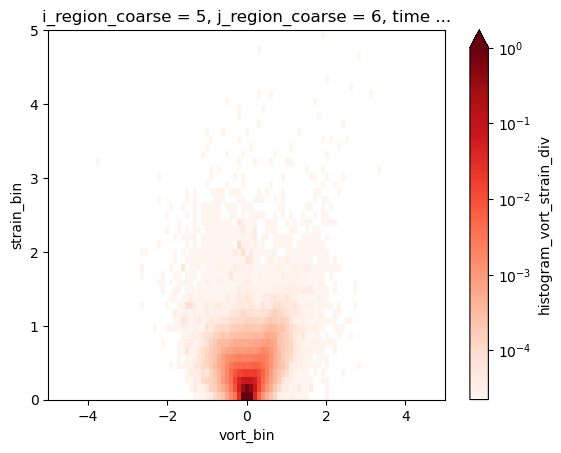

In [94]:
hist1.isel(region=200,time=24).mean('div_bin').plot(x="vort_bin", vmax=1, norm=mpl.colors.SymLogNorm(1e-4), cmap='Reds')

### analyse result

In [13]:
def zero_fraction(h, threshold=1e-5):
    nonzero = xr.where(h < threshold, np.nan, h)
    frac = 1 - (nonzero.count().values / nonzero.size)
    return frac

In [14]:
hist1

<xarray.DataArray 'histogram_vort_strain_div' (time: 3, region: 437,
                                               vort_bin: 99, strain_bin: 49,
                                               div_bin: 99)> Size: 5GB
[629606439 values with dtype=float64]
Coordinates:
    face             (region) int64 3kB ...
  * div_bin          (div_bin) float64 792B -4.949 -4.848 -4.747 ... 4.848 4.949
    i_region_coarse  (region) int64 3kB ...
    region_num       (region) int64 3kB ...
    j_region_coarse  (region) int64 3kB ...
  * time             (time) datetime64[ns] 24B 2011-10-05T03:00:00 ... 2011-1...
  * vort_bin         (vort_bin) float64 792B -4.949 -4.848 ... 4.848 4.949
  * strain_bin       (strain_bin) float64 392B 0.05102 0.1531 ... 4.847 4.949
Dimensions without coordinates: region

In [15]:
1/(1 - zero_fraction(hist1))

np.float64(210.97764115603735)

In [16]:
hist1.isel(time=0).max().values

array(510.71483711)

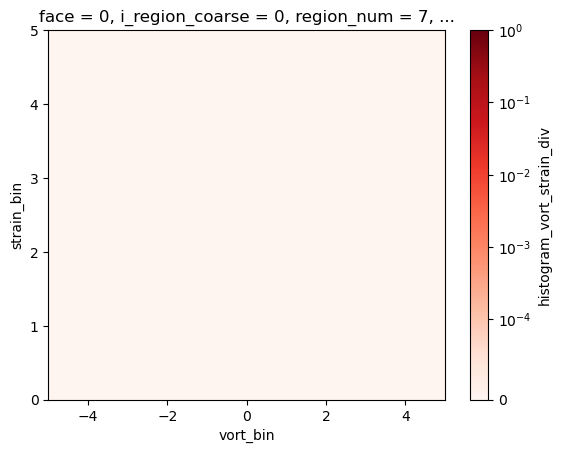

In [20]:
hist1.isel(time=0,region=3).sum(dim="div_bin").plot(x="vort_bin", vmax=1, norm=mpl.colors.SymLogNorm(1e-4), cmap='Reds')

In [18]:
def plot_vort_strain_hist(h):
    
    h = xr.where(h<1e-5, np.nan, h)  # discard values less than threshold
    
    plt.figure(figsize=(10,4.5))
    
    # plot the joint PDF
    h.plot(x="vort_bin", vmax=1e1, vmin=1e-5, norm=mpl.colors.SymLogNorm(1e-4), cmap='Reds')
    
    # plot the lines of perfect correlation / anti-correlation
    strain_max = h.coords["strain_bin"].max()
    plt.plot(np.linspace(0, -strain_max, 10),np.linspace(0, strain_max, 10),'k--',alpha=.5)
    vort_max = h.coords["vort_bin"].max()
    plt.plot(np.linspace(0, vort_max), np.linspace(0, vort_max),'k--',alpha=.5)
    
    # labels
    plt.xlabel('vorticity / $f_0$')
    plt.ylabel('strain / $|f_0|$')
    
    plt.text(0, strain_max / 2, 'Front')
    plt.text(vort_max / 2, strain_max / 4, 'Cyc')
    plt.text(-vort_max / 2, strain_max / 4, 'Acyc')
    
    # grid
    plt.rc('grid', color='black', alpha=.3)
    plt.grid()

In [19]:
hist1 = h.sel(face=1).isel(region=0, time=0)

NameError: name 'h' is not defined

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


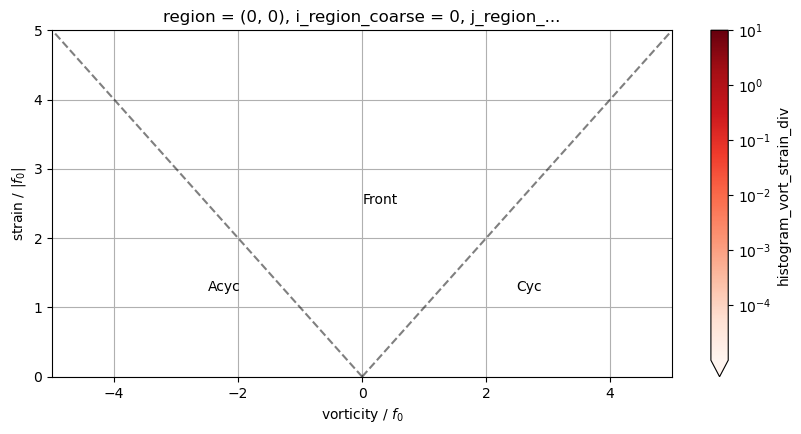

In [66]:
plot_vort_strain_hist(hist1.sum(dim="div_bin"))

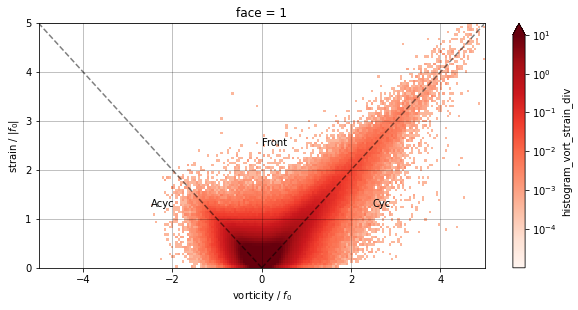

In [52]:
plot_vort_strain_hist(hist2.sum(dim="div_bin"))

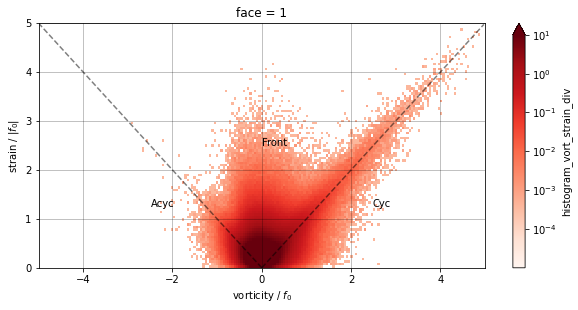

In [53]:
plot_vort_strain_hist(hist3.sum(dim="div_bin"))

In [54]:
def plot_vort_div_hist(h):
    
    h = xr.where(h<1e-5, np.nan, h)  # discard values less than threshold
    
    plt.figure(figsize=(10,4.5))
    
    # plot the joint PDF
    h.plot(x="vort_bin", vmax=1e1, vmin=1e-5, norm=mpl.colors.SymLogNorm(1e-4), cmap='Reds')
    
    # labels
    plt.xlabel('vorticity / $f_0$')
    plt.ylabel('divergence / $|f_0|$')
    
    # grid
    plt.rc('grid', color='black', alpha=.3)
    plt.grid()

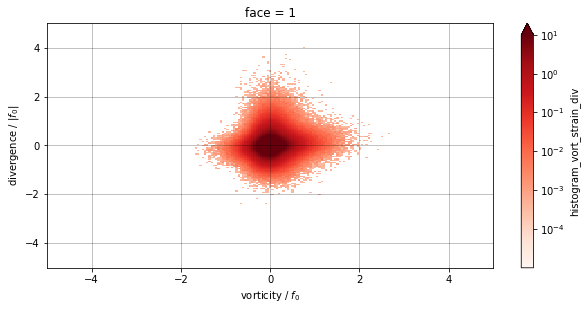

In [55]:
plot_vort_div_hist(hist1.sum(dim="strain_bin"))

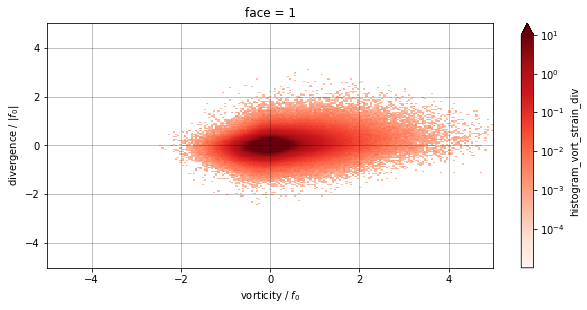

In [56]:
plot_vort_div_hist(hist2.sum(dim="strain_bin"))

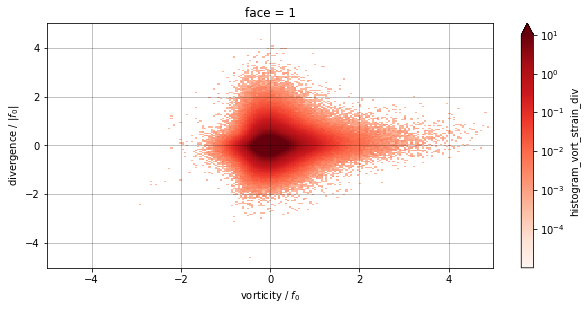

In [57]:
plot_vort_div_hist(hist3.sum(dim="strain_bin"))

In [58]:
np.abs(hist1.sum(dim="strain_bin")).mean()

<xarray.DataArray 'histogram_vort_strain_div' ()>
array(0.198)
Coordinates:
    face     int64 1

In [59]:
hist1

<xarray.DataArray 'histogram_vort_strain_div' (vort_bin: 199, strain_bin: 99,
                                               div_bin: 199)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * vort_bin    (vort_bin) float64 -4.975 -4.925 -4.874 ... 4.874 4.925 4.975
  * strain_bin  (strain_bin) float64 0.02525 0.07576 0.1263 ... 4.924 4.975
  * div_bin     (div_bin) float64 -4.975 -4.925 -4.874 ... 4.874 4.925 4.975
    face        int64 1

In [60]:
zero_fraction(hist1)

0.9864856488931638

In [62]:
hist1.nbytes / 1e6

31.363992

In [66]:
hist1.to_dataset().to_zarr("hist1")

In [67]:
import zarr

In [68]:
z = zarr.open_group("hist1")

In [73]:
z['histogram_vort_strain_div'].info

Name,/histogram_vort_strain_div
Type,zarr.core.Array
Data type,float64
Shape,"(199, 99, 199)"
Chunk shape,"(50, 25, 100)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,31363992 (29.9M)
No. bytes stored,728746 (711.7K)
